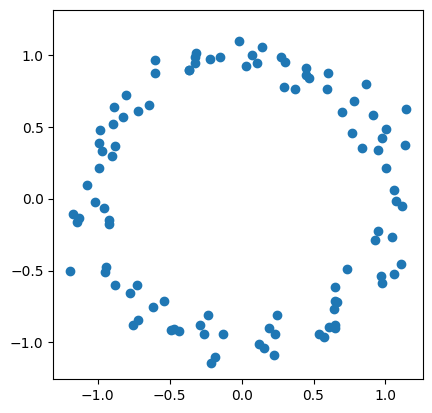

In [1]:
import numpy as np
import recycle as re
import matplotlib.pyplot as plt
from ripser import Rips
from persim import plot_diagrams
from scipy.linalg import svdvals

x = np.linspace(0, 8 * np.pi, 100)
points = np.c_[np.sin(x), np.cos(x)]
circle = points + np.random.normal(0, 0.1, size=(points.shape))

plt.scatter(circle[:, 0], circle[:, 1])
plt.axis("square")
plt.show()


In [2]:
# GET THE INITIAL REPRESENTATIVE
def boundary_and_representative(points,max_edge_length,slack_factor = 1):
    dimension = 2
    #max_edge_length = death * 1.01  # give a bit of slack
    assert slack_factor <= 1
    
    gudhi_complex = re.core.create_simplicial_complex(points, max_edge_length, dimension)
    (
        representative,
        boundary_map,
        reduced_boundary_base,
        (birth_simplex,death_simplex)
    ) = re.core.get_representative_and_complex(gudhi_complex, dimension)
    
    # Get the actual values of birth and death
    birth,death = gudhi_complex.filtration(birth_simplex),gudhi_complex.filtration(death_simplex)
    min_persistence = (death - birth) * slack_factor
    
    order_function = lambda s: (gudhi_complex.filtration(s), s)
    # ISOLATED
    np1_simplices = sorted(
        {
            simplex
            for simplex in reduced_boundary_base
            if gudhi_complex.filtration(simplex) <= (death - min_persistence)*1.01 #slack for rounding errors
        },
        key=order_function,
    )
    n_simplices = sorted(
        {
            tuple(sorted(simplex))
            for simplex, radius in gudhi_complex.get_filtration()
            if len(simplex) == dimension and radius <= (death - min_persistence)*1.01 #slack for rounding errors
        },
        key=order_function,
    )
    nm1_simplices = sorted(
        {
            tuple(sorted(simplex))
            for simplex, radius in gudhi_complex.get_filtration()
            if len(simplex) == dimension - 1 and radius <= (death - min_persistence)*1.01 #slack for rounding errors
        },
        key=order_function,
    )
            
    x_orig = re.core.lift_representative(representative, nm1_simplices, n_simplices)
    boundary_matrix = re.core.build_boundary_matrix(n_simplices, np1_simplices)
    return boundary_matrix, x_orig, n_simplices, representative, (birth_simplex,death_simplex)

In [3]:
#helper function to create the length weight matrix
def edge_length_function(points):
    def edge_length(simp1, simp2):
        if simp1 == simp2:
            return np.linalg.norm(points[simp1[0]] - points[simp1[1]])
        else:
            return 0

    return edge_length

def optimize_cycle(W, x_orig, boundary_matrix, n_simplices):
    # Run optimization
    x_min, status, objective_value = re.core.find_minimal_homologous_cycle(
        boundary_matrix, x_orig, W, use_gurobi=True,verbose=False
    )
    print("Objective value (L1 norm of x):", objective_value)
    min_cycle = set(
        [n_simplices[index] for index in np.argwhere(~np.isclose(x_min, 0)).flatten()]
    )  # be carefull here with values close to zero, add a tolerance parameter
    return min_cycle

def barcode_biggest_cycle(diags):
    persistence = diags[1][:, 1] - diags[1][:, 0]
    cycle = np.argmax(persistence)
    birth, death = diags[1][cycle]
    return birth,death

In [4]:
import contextlib
import os
def compute_cycles(rips,circle, noise,slack):
    if noise is not None:
        perturbed_points = circle+np.random.normal(0, noise, size=(circle.shape))
    else:
        perturbed_points = circle
    diags = rips.fit_transform(perturbed_points)
    _,death = barcode_biggest_cycle(diags)
    max_edge_length = death*1.01
    boundary_matrix,x_orig,n_simplices,_,_ = boundary_and_representative(perturbed_points,
                                                                        max_edge_length,
                                                                        slack_factor=slack)
    W = re.core.create_weight_matrix(n_simplices, edge_length_function(perturbed_points))
    #surpress output
    with contextlib.redirect_stdout(open(os.devnull, 'w')):
        len_cycle = optimize_cycle(W, x_orig, boundary_matrix, n_simplices)
        l0_cycle = optimize_cycle(None, x_orig, boundary_matrix, n_simplices)
    return len_cycle,l0_cycle

In [6]:
from tqdm.notebook import tqdm
results = []
rips= Rips()
N_ITERATIONS = 100
for PERTURB_AMOUNT in [0.01,0.05,0.1]:
    for SLACK in [1, 0.5,0.25,0.1]:
        len_cycles,l0_cycles = [],[]
         # Progress bar for the inner loop
        with tqdm(range(N_ITERATIONS), desc=f"Perturb={PERTURB_AMOUNT}, Slack={SLACK}", unit="iter") as pbar:
            for _ in pbar:
                # Simulate computation
                len_cycle, l0_cycle = compute_cycles(rips,circle, PERTURB_AMOUNT, SLACK)
                len_cycles.append(len_cycle)
                l0_cycles.append(l0_cycle)
        results.append({
            "noise": PERTURB_AMOUNT,
            "slack": SLACK,
            "objective": "len",
            "cycles": len_cycles,
        })
        
        results.append({
            "noise": PERTURB_AMOUNT,
            "slack": SLACK,
            "objective": "l0",
            "cycles": l0_cycles,
        })

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


Perturb=0.01, Slack=1:   0%|          | 0/100 [00:00<?, ?iter/s]

Perturb=0.01, Slack=0.5:   0%|          | 0/100 [00:00<?, ?iter/s]

Perturb=0.01, Slack=0.25:   0%|          | 0/100 [00:00<?, ?iter/s]

Perturb=0.01, Slack=0.1:   0%|          | 0/100 [00:00<?, ?iter/s]

Perturb=0.05, Slack=1:   0%|          | 0/100 [00:00<?, ?iter/s]

Perturb=0.05, Slack=0.5:   0%|          | 0/100 [00:00<?, ?iter/s]

Perturb=0.05, Slack=0.25:   0%|          | 0/100 [00:00<?, ?iter/s]

Perturb=0.05, Slack=0.1:   0%|          | 0/100 [00:00<?, ?iter/s]

Perturb=0.1, Slack=1:   0%|          | 0/100 [00:00<?, ?iter/s]

Perturb=0.1, Slack=0.5:   0%|          | 0/100 [00:00<?, ?iter/s]

Perturb=0.1, Slack=0.25:   0%|          | 0/100 [00:00<?, ?iter/s]

Perturb=0.1, Slack=0.1:   0%|          | 0/100 [00:00<?, ?iter/s]

In [14]:
#BASELINE
#baselines
len_baseline,l0_baseline={},{}
for SLACK in [1,0.5,0.25,0.1]:
    len_cycle, l0_cycle = compute_cycles(rips,circle, None, SLACK)
    len_baseline[SLACK] = len_cycle
    l0_baseline[SLACK] = l0_cycle

In [8]:
import pandas as pd
df = pd.DataFrame(results)

In [46]:
from collections import Counter
def get_stability_distribution(original_selection, new_selections):
    # Convert original selection to set for faster lookup
    original_items = set(original_selection)
    n_trials = len(new_selections)
    
    # Count appearances of each original item
    item_counts = Counter()
    for new_selection in new_selections:
        # Only count items that were in original selection
        for item in set(new_selection) & original_items:
            item_counts[item] += 1
    
    # Calculate percentage for each original item
    stability_dist = {
        item: (item_counts[item] / n_trials)
        for item in original_items
    }
    
    return stability_dist

def compare_sets(set_A, set_list, norm):
    return [norm(set_A,set_B) for set_B in set_list]

def get_intersection_over_union(original_selection, new_selections):
    # Convert original selection to set for faster lookup
    original = set(original_selection)
    n_trials = len(new_selections)
    dist = []
    for selection in new_selections:
        selection = set(selection)
        iou = len(original.intersection(selection))/len(original.union(selection)) 
        dist.append(iou)
    
    return dist

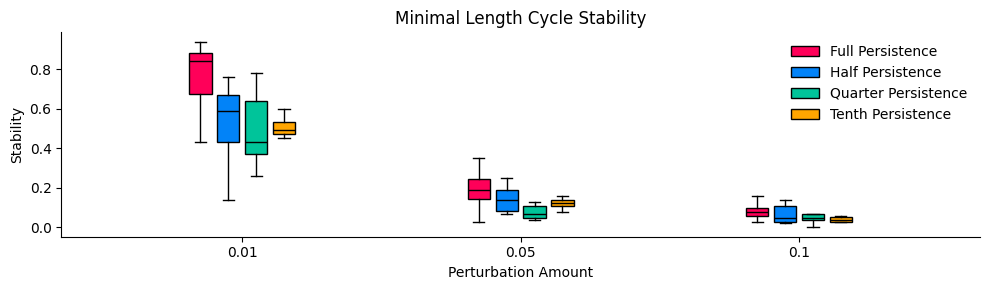

In [183]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Initialize lists for the data
stability_data = {
    1: [],
    0.5: [],
    0.25: [],
    0.1: []
}

# Iterate through unique noise values
x_axis = np.round(df["noise"].unique(), 2)
positions = np.arange(len(x_axis))

# Define offsets and colors for boxplots
slack_values = [1, 0.5, 0.25, 0.1]
offsets = [-0.15, -0.05, 0.05, 0.15]  # Adjust offsets for spacing
colors = ['#FF0059', '#0283F8', '#00C49A', '#FFA500']  # Define unique colors for each slack value
labels = ["Full Persistence", "Half Persistence", "Quarter Persistence", "Tenth Persistence"]

# Extract stability data for each slack value
for noise in x_axis:
    for slack in slack_values:
        cycles = df[
            (np.isclose(df['noise'], noise)) &
            (df['slack'] == slack) &
            (df['objective'] == "len")
        ]['cycles'].tolist()[0]

        stability_data[slack].append(
            list(get_stability_distribution(len_baseline[slack], cycles).values())
        )
        #stability_data[slack].append(compare_sets(len_baseline[slack], cycles,normalized_iou))

# Plot configuration
plt.figure(figsize=(10, 3))
for slack, offset, color in zip(slack_values, offsets, colors):
    # Plot boxplots
    box_plot = plt.boxplot(
        stability_data[slack],
        positions=positions + offset,
        widths=0.08,
        patch_artist=True,
        boxprops=dict(facecolor=color, color='black'),
        medianprops=dict(color='black'),
        flierprops=dict(markerfacecolor=color, markeredgecolor=color),
    )

# Create legend
legend_patches = [
    mpatches.Patch(facecolor=color, edgecolor='black', label=label)
    for color, label in zip(colors, labels)
]
plt.legend(handles=legend_patches, frameon=False)

# Axis labels and title
plt.ylabel("Stability")
plt.xlabel("Perturbation Amount")
plt.title("Minimal Length Cycle Stability")

# Hide unnecessary spines and set ticks
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
plt.xticks(positions, x_axis)

# Show the plot
plt.tight_layout()
plt.savefig("Figures/stability.png")
plt.show()


In [182]:
df.to_csv("stability_secondrun.csv")